<a href="https://colab.research.google.com/github/rajatsatonkar/Taxi-Fare-predictions/blob/main/Taxi_fare_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:

# Reading the csv files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data

In [ ]:
#Displaying train data
train

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748,2.75,1,75.00,24,6.300,105.300,0
1,1187,3.43,1,105.00,24,13.200,142.200,0
2,730,3.12,1,71.25,0,26.625,97.875,1
3,671,5.63,3,90.00,0,9.750,99.750,0
4,329,2.09,1,45.00,12,13.200,70.200,0
...,...,...,...,...,...,...,...,...
209668,1617,8.42,1,150.00,47,5.800,202.800,0
209669,438,1.29,1,48.75,12,34.575,95.325,1
209670,571,2.82,1,63.75,0,6.000,69.750,0
209671,491,2.16,1,56.25,0,13.500,69.750,0


In [ ]:
# Displaying test data
test

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0
...,...,...,...,...,...,...,...,...
89856,435.0,2.24,1.0,0,13,13.700,0,0
89857,519.0,2.61,1.0,0,7,13.850,0,0
89858,450.0,2.24,1.0,0,0,26.625,0,1
89859,919.0,4.12,1.0,0,25,30.200,0,1


In [ ]:

# Describing train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  int64  
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  int64  
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 12.8 MB


In [ ]:

# Describing test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89861 entries, 0 to 89860
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trip_duration       89861 non-null  float64
 1   distance_traveled   89861 non-null  float64
 2   num_of_passengers   89861 non-null  float64
 3   fare                89861 non-null  int64  
 4   tip                 89861 non-null  int64  
 5   miscellaneous_fees  89861 non-null  float64
 6   total_fare          89861 non-null  int64  
 7   surge_applied       89861 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 5.5 MB


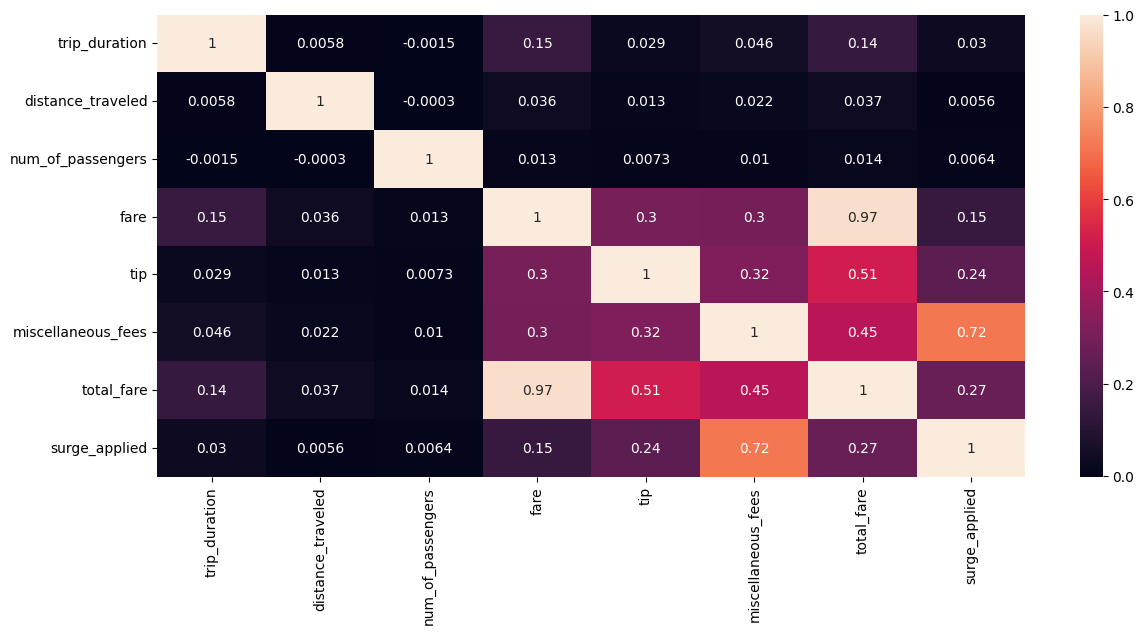

In [ ]:
# To find correlation between different columns
cor=train.corr()
plt.figure(figsize=(14,6))
sns.heatmap(cor,annot=True);

# Feature Selection

In [ ]:
x_fit = train.drop(['fare','total_fare'],axis=1)
y_fit = train['fare']
x_best= SelectKBest(f_regression, k=5).fit(x_fit, y_fit)
mask = x_best.get_support()
features_selection = []
for bool, feature in zip(mask, x_fit.columns):
    if bool:
        features_selection.append(feature)
print('\nFeatures to be worked with are :{}\n\n'.format(features_selection)) # The list of your 5 best features


Features to be worked with are :['trip_duration', 'distance_traveled', 'tip', 'miscellaneous_fees', 'surge_applied']




Setting up features [x] and target [y] data

In [ ]:

#Selecting the important features for prediction
features = features_selection
x = train[features]

# Selecting the target variable (what is to be predicted)
target = 'fare'
y = train[target]

# Model Selection and training

In [ ]:

# Splitting data into train and test datasets
np.random.seed(50)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1)


# Defining and training the ML model
model = XGBRegressor(booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=4,n_estimators=40, n_jobs=36, num_parallel_tree=1,
             random_state=7,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='auto', validate_parameters=1,eval_metric="rmsle")

In [ ]:
#Training the model on training data set
model.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:49] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', feature_types=None, gamma=0, gpu_id=1,
             grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=7, max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=40,
             n_jobs=36, num_parallel_tree=1, ...)

# Prediction and scoring parameters

Prediction the model on test values

In [ ]:
y_preds = model.predict(x_test)

1. Root mean squared log error

In [ ]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_preds))
print(f"Validation RMSLE: {rmsle}")

Validation RMSLE: 0.1724524686960164


2. Mean absolute error

In [ ]:
mae = mean_absolute_error(y_test,y_preds)
print("Validation MAE = ",mae)

Validation MAE =  6.3232537779904465


3. Showing importance of each feature in our prediction model

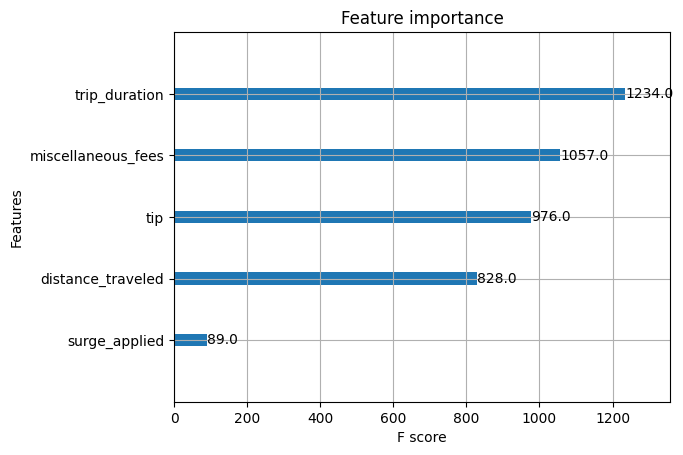

In [ ]:
plot_importance(model)
plt.show()

## Predicting our test dataset "Fare"

In [ ]:
# Predict the fare in the test set
test['fare'] = model.predict(test[features])

## Calculating total fare and loading it to submission.csv

In [ ]:
# Now let's calculate total fare = fare + tip + miscellaneous_fees
test['total_fare'] = test['fare'] + test['tip'] + test['miscellaneous_fees']

# Save the test dataframe with the predictions for the final sample submission
test['total_fare'].to_csv('submission.csv', index=False)

In [ ]:

test

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,99.063057,0,13.500,112.563057,0
1,429.0,1.48,4.0,48.433640,0,13.500,61.933640,0
2,856.0,4.15,1.0,89.119820,24,6.000,119.119820,0
3,622.0,3.22,1.0,69.698273,15,5.625,90.323273,0
4,507.0,3.98,1.0,109.511688,0,2.250,111.761688,0
...,...,...,...,...,...,...,...,...
89856,435.0,2.24,1.0,53.577549,13,13.700,80.277549,0
89857,519.0,2.61,1.0,60.885288,7,13.850,81.735288,0
89858,450.0,2.24,1.0,54.354542,0,26.625,80.979542,1
89859,919.0,4.12,1.0,90.382370,25,30.200,145.582370,1


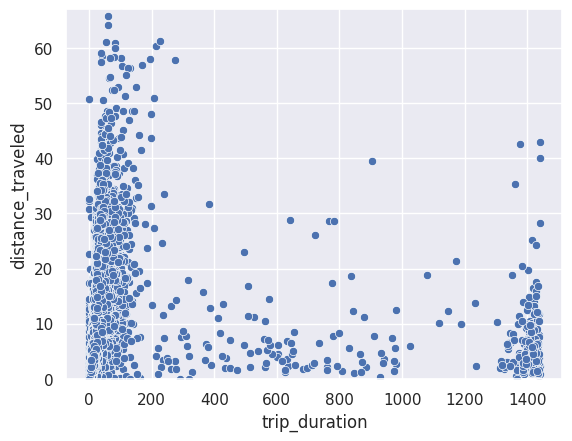

In [ ]:
# Setting up a plot
sns.set_theme()

# Plotting trip duration (in mins) vs distance travelled (in KM)
sns.scatterplot(x=test["trip_duration"].div(60),y=test["distance_traveled"],data=test);

# Setting up a limit of values for distance travelled to get a clearer view of plot
plt.ylim(0,67);

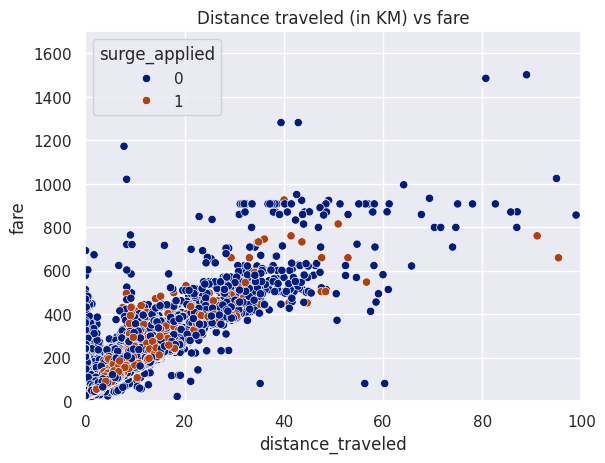

In [ ]:
# Setting up a plot
sns.set_theme()

# Plotting distance travelled (in KM) vs fare
sea=sns.scatterplot(x=test["distance_traveled"],y=test["fare"],data=test,
                    hue="surge_applied",palette="dark").set(title="Distance traveled (in KM) vs fare");

# Setting up a limit of values for distance travelled to get a clearer view of plot
plt.xlim(0,100);
plt.ylim(0,1700);

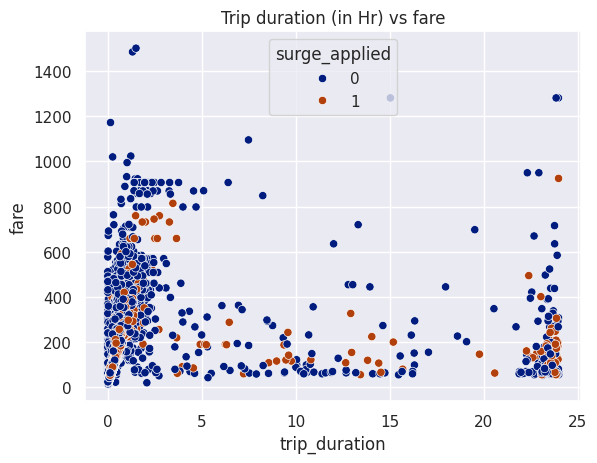

In [ ]:
# Setting up a plot
sns.set_theme()

# Plotting trip duration (in hours) vs fare
sea=sns.scatterplot(x=test["trip_duration"].div(3600),y=test["fare"],data=test,
                    hue="surge_applied",palette="dark").set(title="Trip duration (in Hr) vs fare");

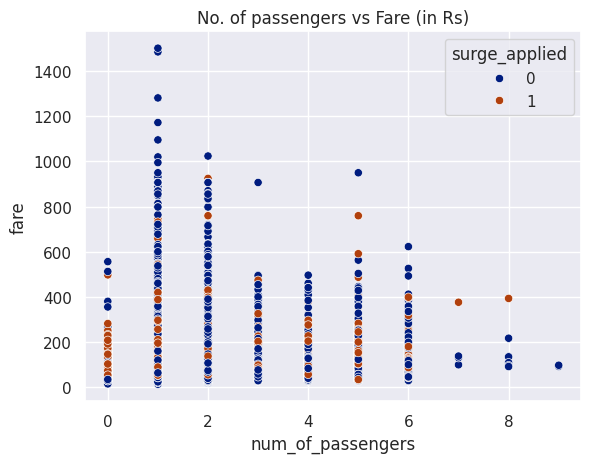

In [ ]:
# Setting up a plot
sns.set_theme()

# Plotting No. of passengers vs Fare (in Rs)
sns.scatterplot(x=test["num_of_passengers"],y=test["fare"],data=test,
                hue="surge_applied",palette="dark").set(title = "No. of passengers vs Fare (in Rs)");

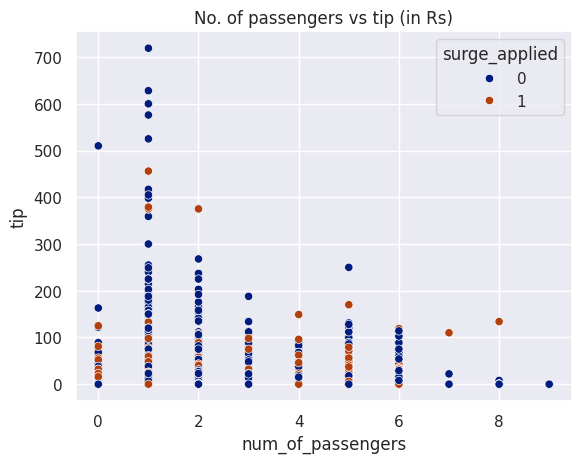

In [ ]:
# Setting up a plot
sns.set_theme()

# Plotting No. of passengers vs tip (in Rs) along with surge
sns.scatterplot(x=test["num_of_passengers"],y=test["tip"],data=test,
                hue="surge_applied",palette="dark").set(title = "No. of passengers vs tip (in Rs)");